In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

%matplotlib inline 


In [2]:
# 数据读取
wild_blueberry = pd.read_csv('../data/Wild_blueberry_production_forecast/WildBlueberryPollinationSimulationData.csv',sep=',')

In [3]:
# 去除冗余的列
wild_blueberry = wild_blueberry.drop(['Row#'],axis=1)

In [4]:
# 观察各列数据类型 发现全部为数值型
wild_blueberry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   clonesize             777 non-null    float64
 1   honeybee              777 non-null    float64
 2   bumbles               777 non-null    float64
 3   andrena               777 non-null    float64
 4   osmia                 777 non-null    float64
 5   MaxOfUpperTRange      777 non-null    float64
 6   MinOfUpperTRange      777 non-null    float64
 7   AverageOfUpperTRange  777 non-null    float64
 8   MaxOfLowerTRange      777 non-null    float64
 9   MinOfLowerTRange      777 non-null    float64
 10  AverageOfLowerTRange  777 non-null    float64
 11  RainingDays           777 non-null    float64
 12  AverageRainingDays    777 non-null    float64
 13  fruitset              777 non-null    float64
 14  fruitmass             777 non-null    float64
 15  seeds                 7

In [5]:
# 采用pycaret回归模块处理
from pycaret.regression import *

# 对wild_blueberry进行回归建模的环境设置。标签列为yield，其余列为特征，训练集比例为80%，自动进行
# 默认自动进行数据预处理（包括缺失值填充等操作，可以设置为False,此处不设置），五折交叉验证
# 要求进行归一化、方法设为robust(scales and translates each feature according to the Interquartile range)
# 设置随机种子666
wild_blueberry_regression = setup(data = wild_blueberry, target = 'yield', 
                                  train_size = 0.8,fold=5,
                                  normalize = True, normalize_method = 'robust',
                                  session_id = 666 )

,Description,Value
0,session_id,666
1,Target,yield
2,Original Data,"(777, 17)"
3,Missing Values,False
4,Numeric Features,16
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(621, 10)"


In [6]:
# 比较pycaret中所有可用分类模型在该数据集上的表现，发现线性回归最佳
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,106.3818,19915.6324,140.5377,0.9890,0.0284,0.0194,0.5280
br,Bayesian Ridge,106.5249,19923.4165,140.5870,0.9890,0.0286,0.0195,0.0040
huber,Huber Regressor,105.2938,20019.1573,140.6398,0.9889,0.0279,0.0191,0.0080
lasso,Lasso Regression,108.9458,20883.4840,144.0209,0.9884,0.0305,0.0201,0.4260
et,Extra Trees Regressor,116.9816,23486.3602,153.1343,0.9871,0.0316,0.0216,0.0460
ridge,Ridge Regression,118.1700,24116.9848,154.7710,0.9867,0.0334,0.0218,0.3820
gbr,Gradient Boosting Regressor,123.1382,25386.6006,159.2605,0.9860,0.0320,0.0225,0.0180
xgboost,Extreme Gradient Boosting,127.7555,26208.1195,161.7118,0.9857,0.0328,0.0236,0.1520
par,Passive Aggressive Regressor,123.1666,28613.4967,168.0585,0.9843,0.0423,0.0235,0.0060
rf,Random Forest Regressor,127.6586,28884.6766,169.2365,0.9842,0.0341,0.0236,0.0540


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [7]:
# 创建线性模型，不传递初始参数
lr = create_model('lr') 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,119.0158,26813.1777,163.7473,0.9832,0.0307,0.0213
1,101.2513,16951.8262,130.1992,0.9905,0.0235,0.0177
2,107.5105,21063.5840,145.1330,0.9886,0.0313,0.0198
3,104.3226,16967.9297,130.2610,0.9908,0.0310,0.0203
4,99.8089,17781.6445,133.3478,0.9917,0.0257,0.0180
Mean,106.3818,19915.6324,140.5377,0.9890,0.0284,0.0194
SD,6.8507,3766.1898,12.8374,0.0030,0.0032,0.0014


In [8]:
# 选择默认参数下最佳的基础模型：线性回归，进行自动参数搜索
# 搜索参数库指定scikit-optimize ；搜索算法指定贝叶斯搜索，目标指定为R2最佳
lr_tune = tune_model(lr,optimize = 'R2',
                      search_library = 'scikit-optimize',search_algorithm = 'bayesian')  

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,119.0159,26813.1699,163.7473,0.9832,0.0307,0.0213
1,101.2514,16951.8086,130.1991,0.9905,0.0235,0.0177
2,107.5105,21063.5840,145.1330,0.9886,0.0313,0.0198
3,104.3225,16967.8574,130.2607,0.9908,0.0310,0.0203
4,99.8090,17781.6504,133.3479,0.9917,0.0257,0.0180
Mean,106.3818,19915.6141,140.5376,0.9890,0.0284,0.0194
SD,6.8507,3766.2003,12.8374,0.0030,0.0032,0.0014


In [9]:
lr_tune #查看搜索后的最佳参数

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True)

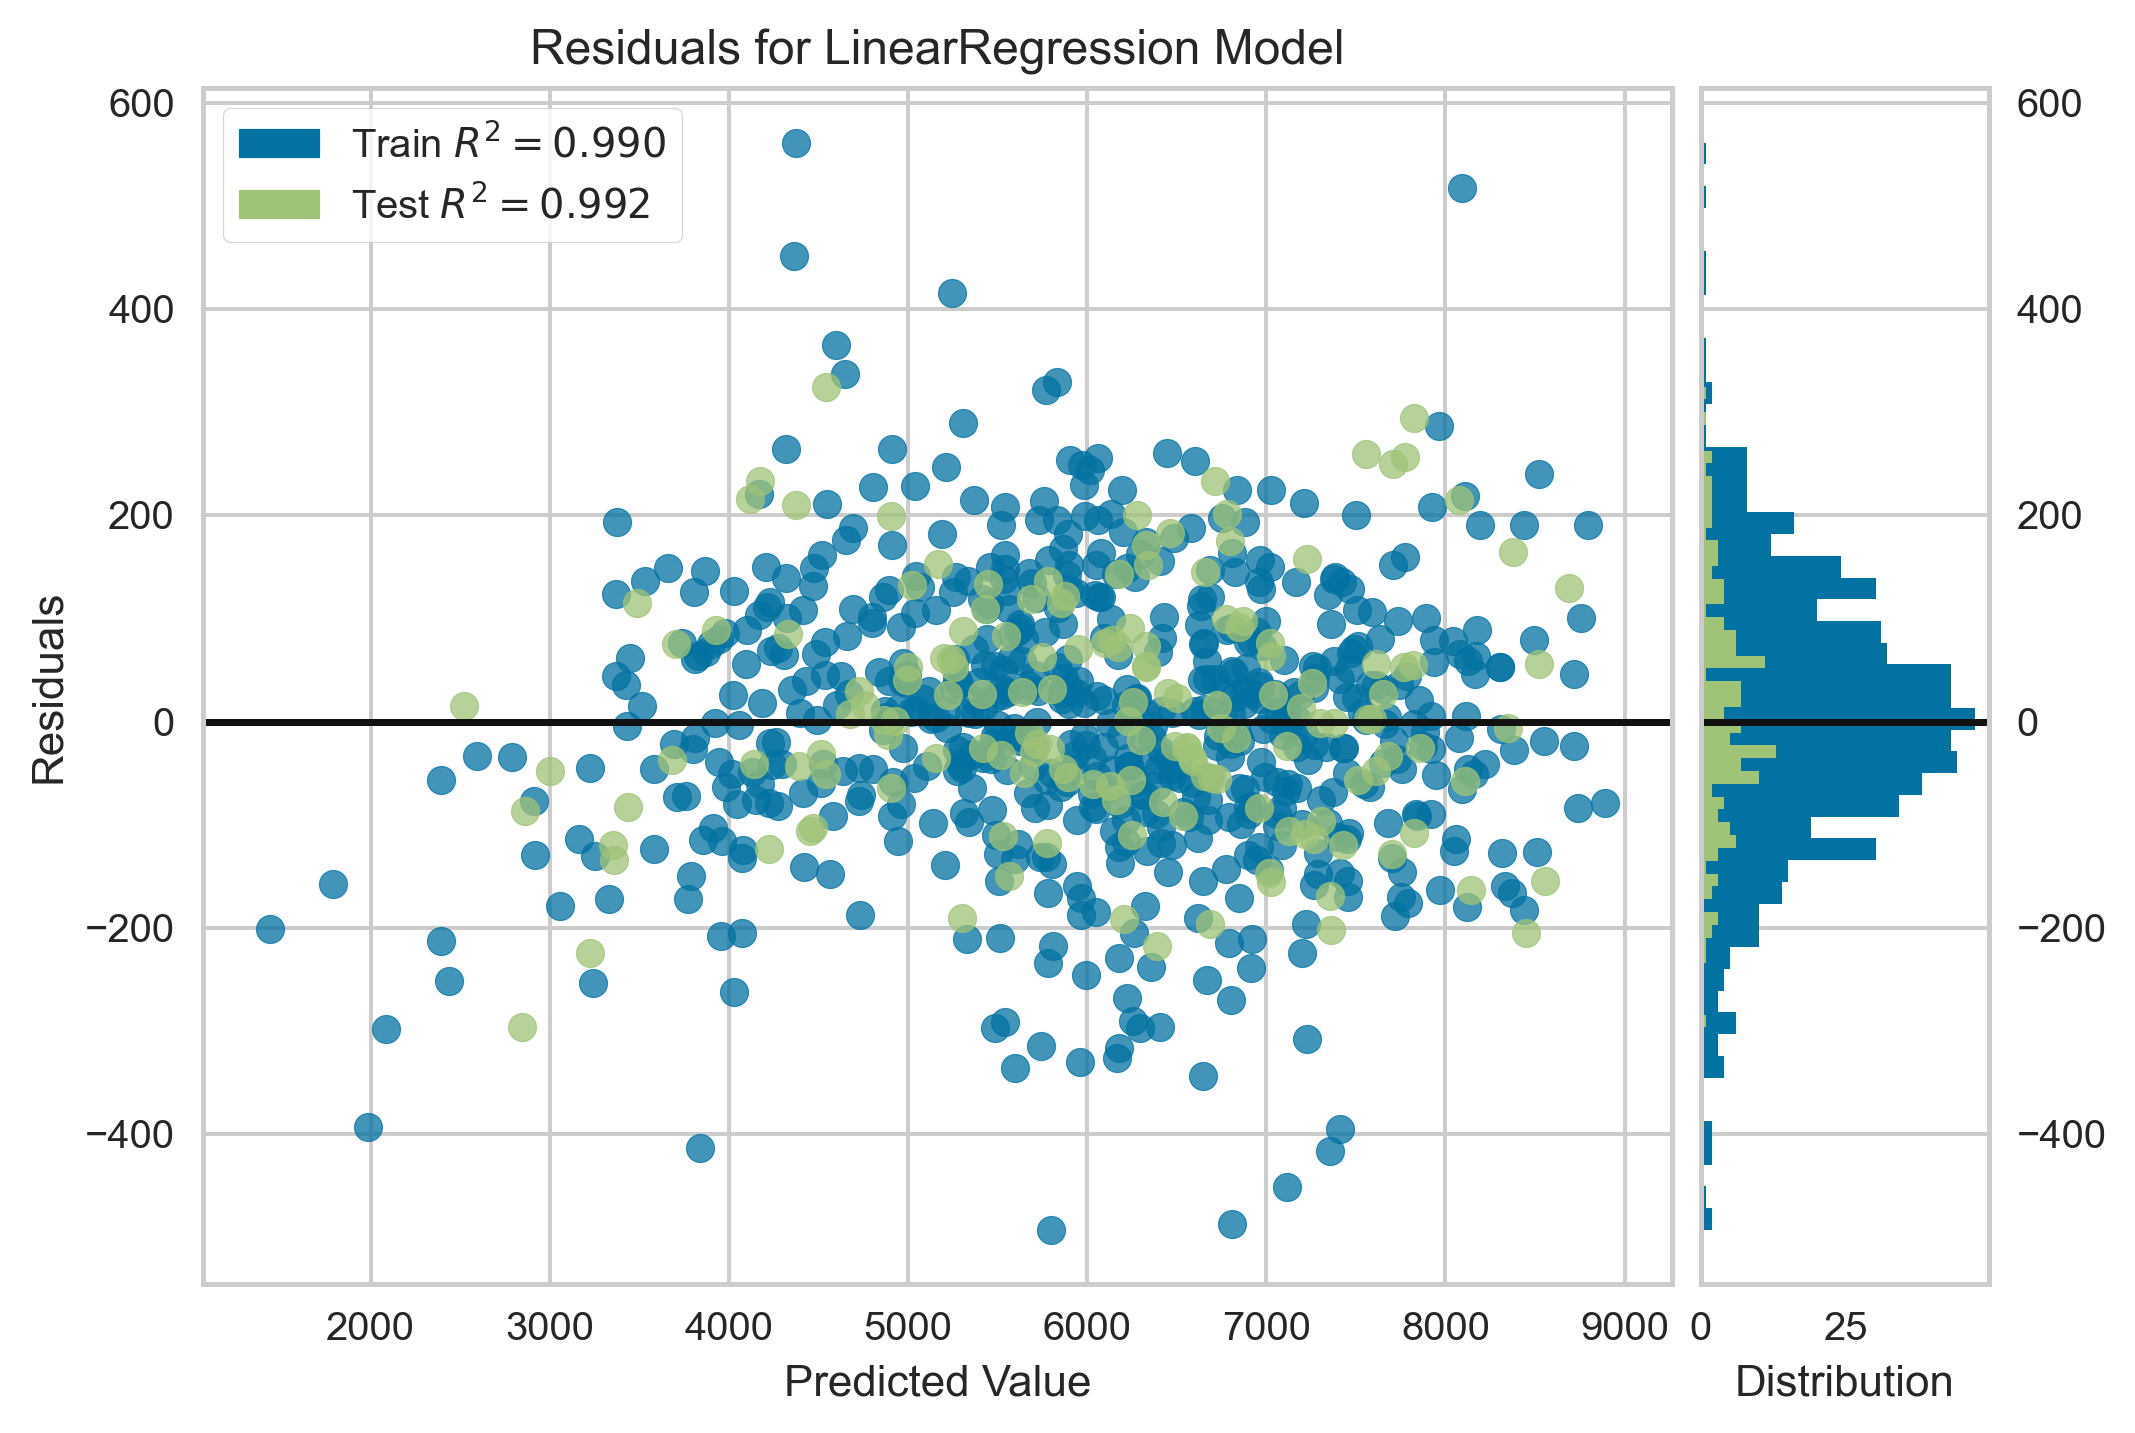

In [10]:
# 对模型进行训练性能分析（可视化展示）
# pycaret.regression.evaluate_model(lr_tune) #调用所有展示方法

# 同时显示训练和测试的结果 ，scale设置分辨率比例
plot_model(lr_tune, plot = 'residuals',scale=4)


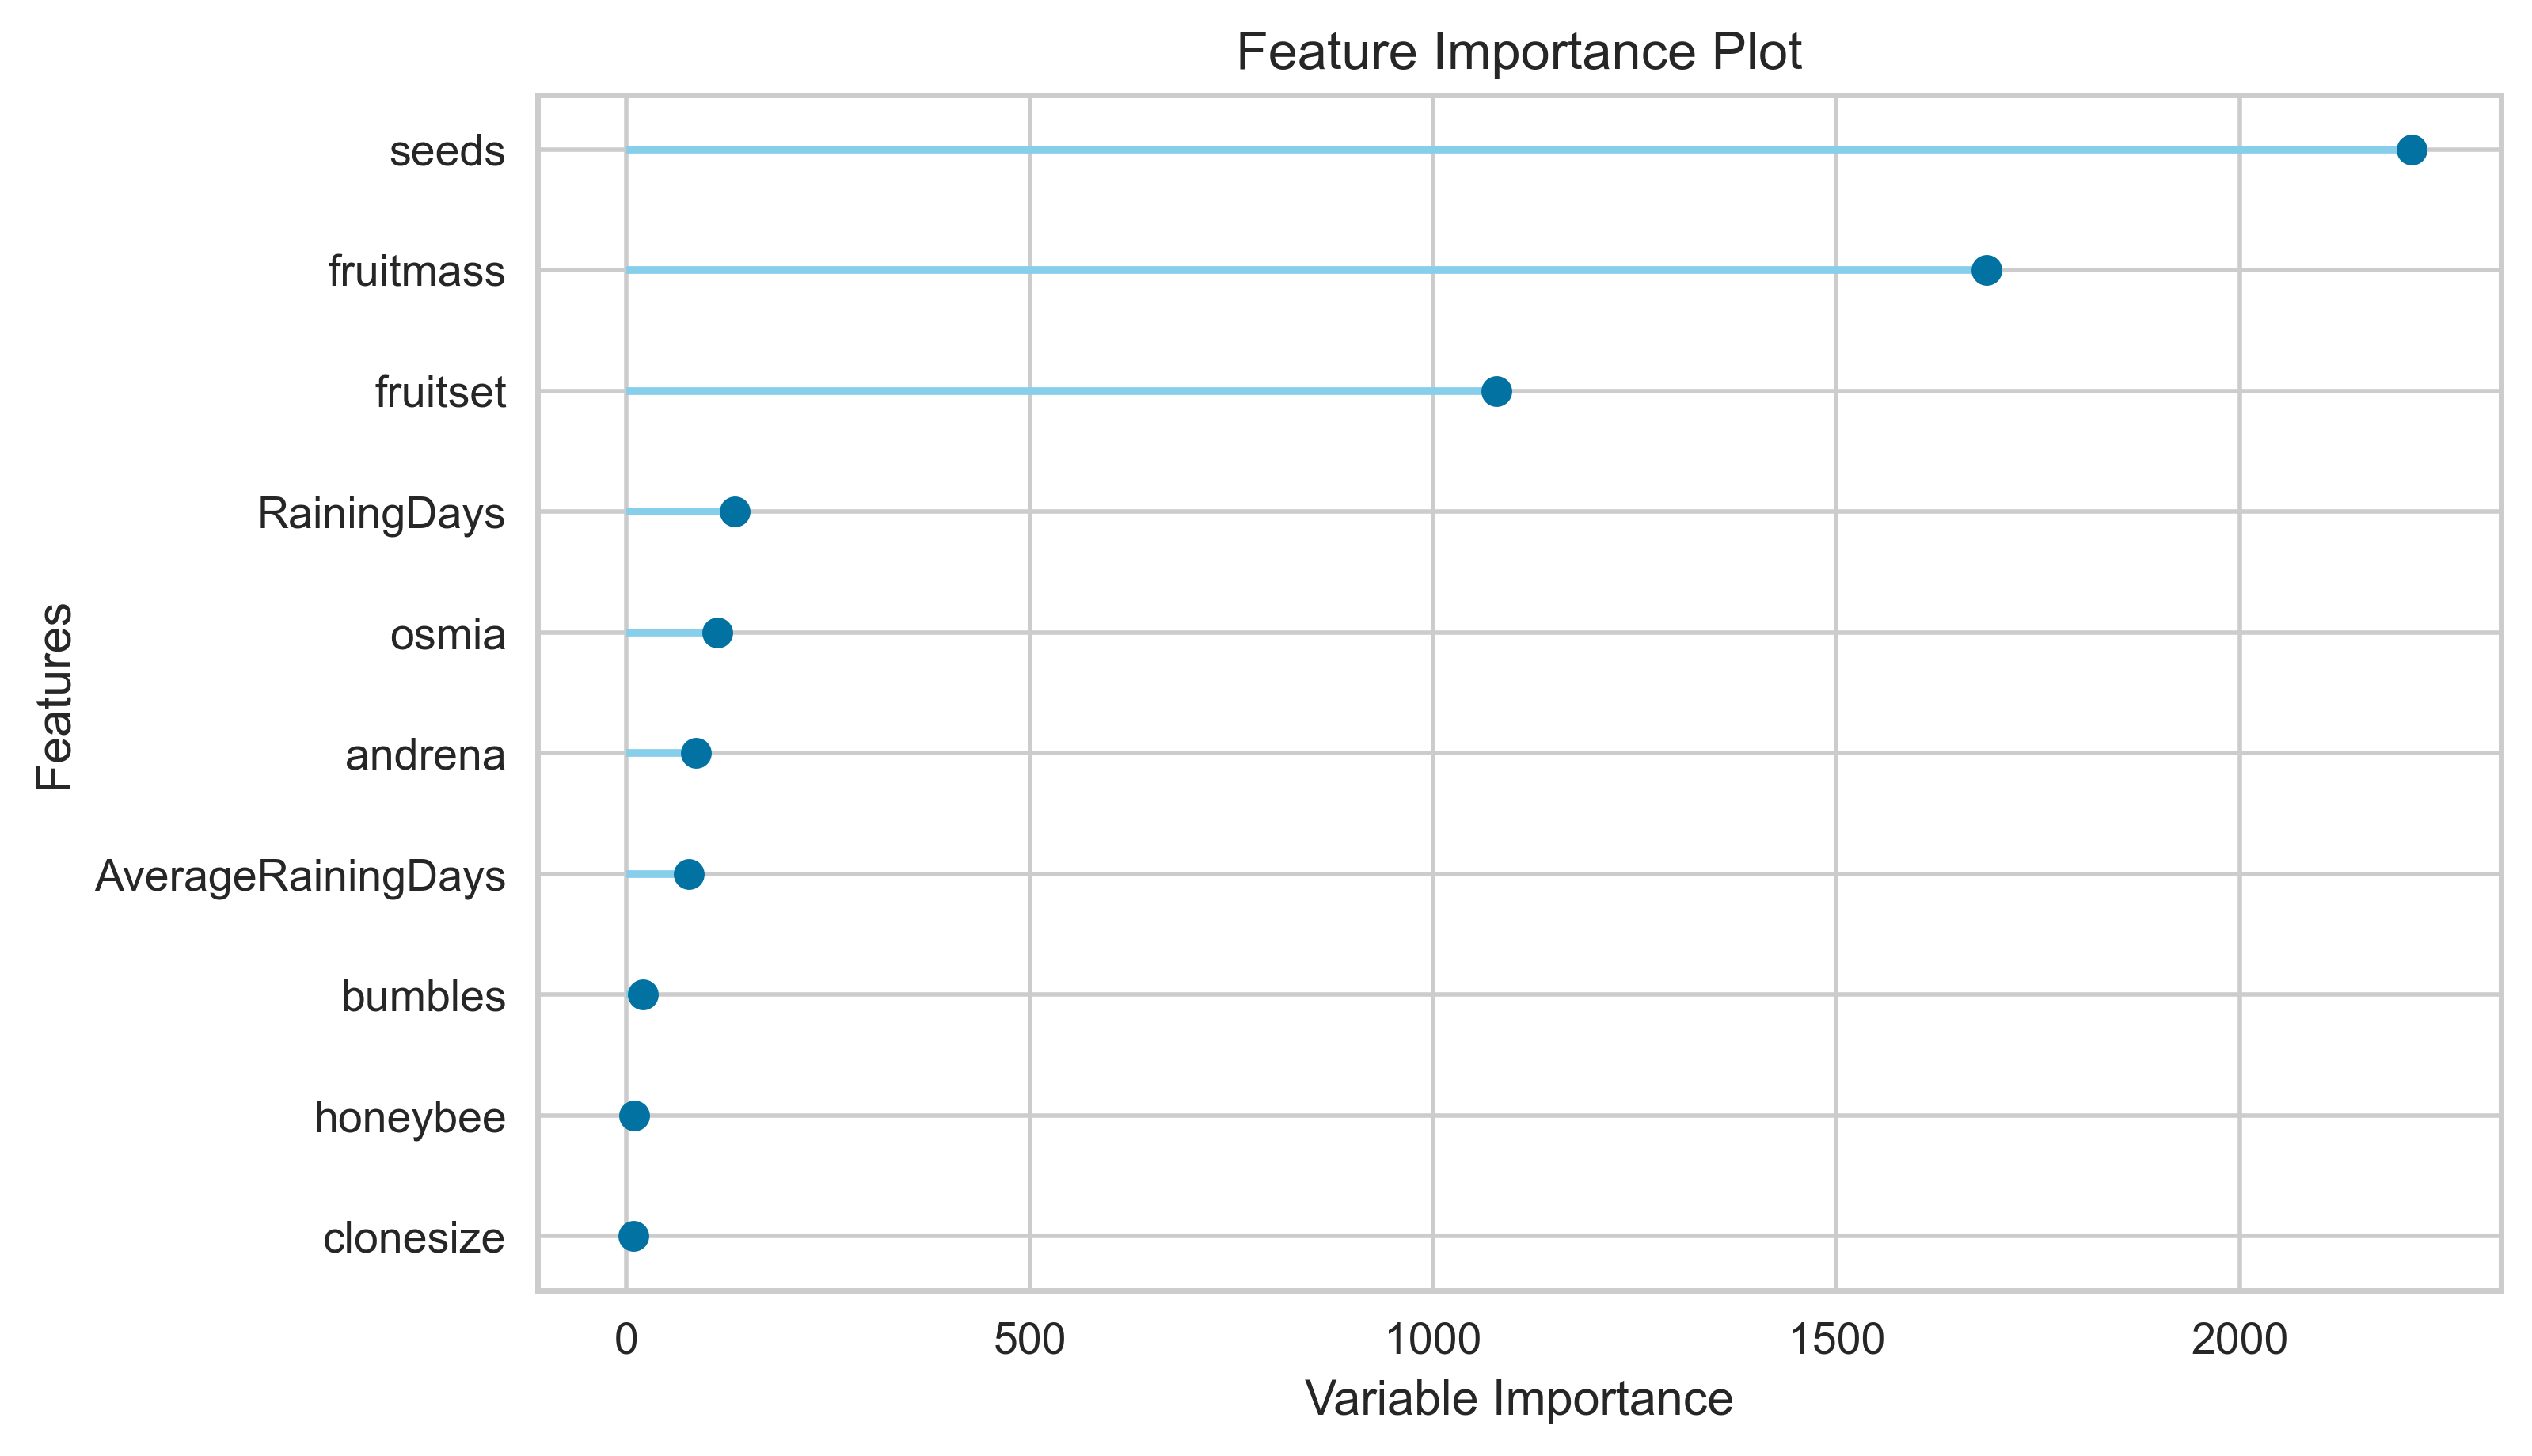

In [15]:
# 变量重要性评估（辅助确定对预测最重要的变量）
plot_model(lr_tune, plot = 'feature',scale=4)

In [12]:
# 完成预测 和 效果评估，在测试集上(以数值的形式展示)
predict_model(lr_tune)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,91.7054,13508.8779,116.2277,0.9925,0.0218,0.0162


,clonesize,honeybee,bumbles,andrena,osmia,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield,Label
0,0.6,-1.0,-1.476923,-0.364,-2.052,-0.531739,-0.689655,-1.601960,-1.180793,-1.315583,3471.192139,3351.791992
1,0.0,0.0,0.000000,-0.480,0.480,0.000000,0.000000,0.278709,-0.041831,0.147192,6846.006836,6829.784180
2,1.0,1.0,0.000000,0.000,-0.520,0.782609,1.034483,-0.530277,-0.311436,-0.419364,4968.601074,4904.427734
3,0.0,0.0,0.000000,-1.000,-1.520,0.782609,1.034483,-0.936874,-1.107157,-0.995730,4247.508789,4332.548828
4,0.0,0.0,0.000000,0.520,0.000,0.347826,0.448276,0.596772,0.602254,0.590626,6942.396484,7018.742188
...,...,...,...,...,...,...,...,...,...,...,...,...
151,0.0,0.0,0.000000,-0.480,-1.000,0.347826,0.448276,0.281669,0.315082,0.263841,6299.226562,6242.111816
152,1.0,1.0,0.000000,0.520,0.480,-0.652174,-0.551724,0.221199,0.323386,0.289416,6880.775879,6684.291504
153,1.0,1.0,0.000000,-0.480,-0.520,0.782609,1.034483,-0.619737,-0.372204,-0.485078,4694.608398,4723.821289
154,1.0,1.0,1.000000,0.000,0.480,-0.652174,-0.551724,-0.071137,-0.216700,-0.105036,6189.779785,6341.667969


In [13]:
# 模型保存（获得pkl文件），可以用load_model加载
# save_model(lr_tune, 'wild_blueberry_lr_model')